# Libraries

In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
# Animation
from IPython import display

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 


cuda


# Tunning Parameters

In [2]:
# '''Training parameters'''
steps=20000 # step
lr=1e-4 # learning rate
layers = np.array([2,128,256,128,1]) # input x and t, outputs p

'''Loss points'''
#Nu: Number of training points 
N_u = 100 #Total number of data points for 'u'
# Nf: Number of collocation points (Evaluate PDE)
N_f = 1000 #Total number of collocation points

'''Mesh'''
# Domain mesh
L_x = 1   # Range of the domain according to x [m]
dx = 0.01 # Mesh size
N_x = int(L_x/dx) # Points number of the spatial mesh
X = np.linspace(-L_x,L_x,N_x+1) # Spatial array

# Time step mesh
L_t = 0.2 #Duration of simulation [s]
dt = 0.2*dx  #Infinitesimal time with CFL (Courant–Friedrichs–Lewy condition)
N_t = int(L_t/dt) #Points number of the temporal mesh
T = np.linspace(0,L_t,N_t+1) #Temporal array

'''Source parameter'''
x0 = 0.0 # Source position
sigma = 0.05 # Source width

# Auxiliary Functions


In [3]:
def plot3D(x,t,y):
    X,T= np.meshgrid(x,t)
    F_xt = y
    fig,ax=plt.subplots(1,1)
    cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
    fig.colorbar(cp) # Add a colorbar to a plot
    ax.set_title('F(x,t)')
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    plt.show()
    ax = plt.axes(projection='3d')
    ax.plot_surface(T, X, F_xt,cmap="rainbow")
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.set_zlabel('f(x,t)')
    plt.show()
    
def plot3D_Train(x,t,y,step,loss):
    X,T= x,t
    F_xt = y
    fig,ax=plt.subplots(1,1)
    cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
    fig.colorbar(cp) # Add a colorbar to a plot
    ax.set_title("step: {},loss: {:.2f}".format(step, loss) )
    ax.set_xlabel('t')
    ax.set_ylabel('x')

def plot3D_Matrix(x,t,y):
    X,T= x,t
    F_xt = y
    fig,ax=plt.subplots(1,1)
    cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
    fig.colorbar(cp) # Add a colorbar to a plot
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    plt.show()
    ax = plt.axes(projection='3d')
    ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.set_zlabel('f(x,t)')
    plt.show()

# Problem Setup

**Wave Equation**

$$\frac{\partial^2 p}{\partial t^2}=c^2 \frac{\partial^2 p}{\partial x^2} $$

$$x\in[-1,1]$$
$$t\in[0,1]$$

## Initial and Boundary Conditions:
**Gaussian impulse as initial condition**
$$p(x,t = 0,x_0) = \exp^{-(\frac{x-x_0}{\sigma_0})^2} 
$$
**Neumann boundary condition**
$$\frac{dp(x=1,t)}{dx}=0 \\ \frac{dp(x=-1,t)}{dx}=0$$

# Analysis:
## PDE

Let:

$p_{t}=\frac{\partial p}{\partial t}$

$p_x=\frac{\partial p}{\partial x}$

$p_{xx}=\frac{\partial^2 p}{\partial x^2}$

So:

$$p_{tt}=c^2 p_{xx}$$

If we rearrange our PDE, we get:

$$p_{tt}-c^2 p_{xx}=0$$

## Neural Network

A Neural Network is a function (See:https://book.sciml.ai/notes/03/):

$$NN(X)=W_n\sigma_{n-1}(W_{n-1}\sigma_{n-2}(...(W_2(W_1X+b_1)+b_2)+..)+b_{n-1})+b_n$$

**Note:**We usually train our NN by iteratively minimizing a loss function ($MSE$:mean squared error) in the training dataset(known data).
 
## PINNs=Neural Network + PDE 
(See: https://www.sciencedirect.com/science/article/pii/S0021999118307125)

We can use a neural network to approximate any function (Universal APproximation Theorem): (See:https://book.sciml.ai/notes/03/)
$$NN(x,t)\approx p(x,t)$$ 

Since NN is a function, we can obtain its derivatives: $\frac{\partial NN}{\partial t},\frac{\partial^2 NN}{\partial x^2}$.(Automatic Diferentiation) 

Assume:$$NN(t,x)\approx p(t,x)$$ 

Then:

$$\frac{\partial^2 NN}{\partial t^2}-c^2\frac{\partial^2 NN}{\partial x^2}\approx p_{tt}-c^2 p_{xx}=0$$




We define this function as $f$:

$$f(t,x)=\frac{\partial^2 NN}{\partial t^2}-c^2\frac{\partial^2 NN}{\partial x^2}$$

If $f\rightarrow 0$ then our NN would be respecting the physical law.

### PINNs' Loss function

We evaluate our PDE in a certain number of "collocation points" ($N_f$) inside our domain $(x,t)$. Then we iteratively minimize a loss function related to $f$:

$$MSE_f=\frac{1}{N_f}\sum^{N_f}_{i=1}|f(t_f^i,x_f^i)|^2$$

Usually, the training data set is a set of points from which we know the answer. In our case, we will use our boundary(BC) and initial conditions(IC).

Since we know the outcome, we select $N_u$ points from our BC and IC and used them to train our network.

$$MSE_{u}=\frac{1}{N_u}\sum^{N_u}_{i=1}|y(t_{u}^i,x_u^i)-NN(t_{u}^i,x_u^i)|^2$$


#### Total Loss:

$$MSE=MSE_{u}+MSE_f$$

# Neural Network

## Activation function

In [4]:
'''Customize activation function'''
class SinActivation(nn.Module):
    def __init__(self):
        super(SinActivation, self).__init__()
        return
    def forward(self, x):
        return torch.sin(x)

## Main structure

In [5]:
class FCN(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
        
        'activation function'
        self.activation = SinActivation()

        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
    
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        self.iter = 0
    
        'Xavier Normal Initialization for the neural networks'
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)   
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
    '''foward pass'''
    def forward(self,x):
        
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)

#         preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
#         convert to float
        a = x.float()
        
        for i in range(len(layers)-2):

            z = self.linears[i](a)
            a = self.activation(z)
            
        a = self.linears[-1](a)
        
        return a
    
    'Initial condition loss'             
    def loss_IC(self,X_IC,y):
                
        loss_I = self.loss_function(self.forward(X_IC), y)
                
        return loss_I
    
    'Boundary condition loss'
    def loss_BC(self,X_BC):
        
        g = X_BC.clone()
        
        g.requires_grad = True
        
        p = self.forward(g)
        
        p_x_t = autograd.grad(p,g,torch.ones([X_BC.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        
        p_x = p_x_t[:,[0]] # dp/dx = 0
        
        loss_BC = self.loss_function(p_x,p_x_hat) # dp/dx = 0
        
        return loss_BC
    
    'PDE loss'
    def loss_PDE(self, X_PDE):
                        
        g = X_PDE.clone()
                        
        g.requires_grad = True
        
        p = self.forward(g)
                
        p_x_t = autograd.grad(p,g,torch.ones([X_PDE.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
                                
        p_xx_tt = autograd.grad(p_x_t,g,torch.ones(X_PDE.shape).to(device), create_graph=True)[0]
                                                            
        p_x = p_x_t[:,[0]]
        
        p_t = p_x_t[:,[1]]
        
        p_xx = p_xx_tt[:,[0]]
        
        p_tt = p_xx_tt[:,[1]]
        
        c = 1.0
        
        f = p_tt - c**2*p_xx 
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,X_BC,X_IC,y,X_PDE):

        loss_IC = self.loss_IC(X_IC,y)
        loss_BC = self.loss_BC(X_BC)
        loss_f = self.loss_PDE(X_PDE)
        
        loss_val = 100*loss_IC + loss_BC +10*loss_f
        #loss_val = loss_IC/loss_IC.detach() + loss_BC/loss_BC.detach() + loss_f/loss_f.detach()
    
        return loss_val   
    
    'test neural network'
    def test(self):
                
        u_pred = self.forward(X)
        
        # Relative L2 Norm of the error (Vector)
        error_vec = torch.linalg.norm((u-u_pred),2)/torch.linalg.norm(u,2) 
                
        return error_vec

# Generate data

## FDTD

In [6]:
############## MODULES IMPORTATION ###############
# Def of the initial condition    
def I(x):
    """
    Single space variable fonction that 
    represent the wave form at t = 0
    """
    return np.exp(-(x-x0)**2/sigma)

############## SET-UP THE PROBLEM ###############
'''Medium velocity'''
# Def of velocity (spatial scalar field)
def celer(x):
    """
    constant velocity
    """
    return 1

# def celer(x):
#     """
#     Single space variable fonction that represent 
#     the wave's velocity at a position x
#     """
#     if x <=0.7:
#         return 1
#     else:
#         return 1

left_bound_cond = 2  #Boundary cond 1 : Dirichlet, 2 : Neumann, 3 Mur
right_bound_cond = 2  #Boundary cond 1 : Dirichlet, 2 : Neumann, 3 Mur

# Temporal mesh with CFL < 1 - j indices
# Velocity array for calculation (finite elements)
c = np.zeros(N_x+1, float)
for i in range(0,N_x+1):
    c[i] = celer(X[i])

############## CALCULATION CONSTANTS ###############
c_1 = c[0]
c_2 = c[N_x]

C2 = (c_1*dt/dx)**2

CFL_1 = c_1*(dt/dx)
CFL_2 = c_2*(dt/dx)

############## PROCESSING LOOP ###############
u_jm1 = np.zeros(N_x+1,float)   #Vector array u_i^{j-1}
u_j = np.zeros(N_x+1,float)     #Vector array u_i^j
u_jp1 = np.zeros(N_x+1,float)   #Vector array u_i^{j+1}

q = np.zeros(N_x+1,float)
q[0:N_x+1] = c[0:N_x+1]**2

U = np.zeros((N_x+1,N_t+1),float) #Global solution

#init cond - at t = 0
u_j[0:N_x+1] = I(X[0:N_x+1])
U[:,0] = u_j.copy()

#init cond - at t = 1
#without boundary cond
u_jp1[1:N_x] =  u_j[1:N_x] + 0.5*C2*( 0.5*(q[1:N_x] + q[2:N_x+1])*(u_j[2:N_x+1] - u_j[1:N_x]) - 0.5*(q[0:N_x-1] + q[1:N_x])*(u_j[1:N_x] - u_j[0:N_x-1]))


#left boundary conditions
if left_bound_cond == 1:
    #Dirichlet bound cond
    u_jp1[0] = 0

elif left_bound_cond == 2:
    #Nuemann bound cond
    #i = 0
    u_jp1[0] = u_j[0] + 0.5*C2*( 0.5*(q[0] + q[0+1])*(u_j[0+1] - u_j[0]) - 0.5*(q[0] + q[0+1])*(u_j[0] - u_j[0+1]))

elif left_bound_cond == 3:
    #Mur bound cond
    #i = 0
    u_jp1[0] = u_j[1] + (CFL_1 -1)/(CFL_1 + 1)*( u_jp1[1] - u_j[0])

#right boundary conditions
if right_bound_cond == 1:
    #Dirichlet bound cond
    u_jp1[N_x] = 0


elif right_bound_cond == 2:
    #Nuemann bound cond
    #i = N_x
    u_jp1[N_x] =  u_j[N_x] + 0.5*C2*( 0.5*(q[N_x-1] + q[N_x])*(u_j[N_x-1] - u_j[N_x]) - 0.5*(q[N_x-1] + q[N_x])*(u_j[N_x] - u_j[i-1]))


elif right_bound_cond == 3:
    #Mur bound cond
    #i = N_x
    u_jp1[N_x] = u_j[N_x-1] + (CFL_2 -1)/(CFL_2 + 1)*(u_jp1[N_x-1] - u_j[N_x])

u_jm1 = u_j.copy()  #go to the next step
u_j = u_jp1.copy()  #go to the next step
U[:,1] = u_j.copy()


#Process loop (on time mesh)
for j in range(1, N_t):
    #calculation at step j+1
    #without boundary cond
    u_jp1[1:N_x] = -u_jm1[1:N_x] + 2*u_j[1:N_x] + C2*( 0.5*(q[1:N_x] + q[2:N_x+1])*(u_j[2:N_x+1] - u_j[1:N_x]) - 0.5*(q[0:N_x-1] + q[1:N_x])*(u_j[1:N_x] - u_j[0:N_x-1]))


    #left bound conditions
    if left_bound_cond == 1:
        #Dirichlet bound cond
        u_jp1[0] = 0

    elif left_bound_cond == 2:
        #Nuemann bound cond
        #i = 0
        u_jp1[0] = -u_jm1[0] + 2*u_j[0] + C2*( 0.5*(q[0] + q[0+1])*(u_j[0+1] - u_j[0]) - 0.5*(q[0] + q[0+1])*(u_j[0] - u_j[0+1]))       

    elif left_bound_cond == 3:
        #Mur bound cond
        #i = 0
        u_jp1[0] = u_j[1] + (CFL_1 -1)/(CFL_1 + 1)*( u_jp1[1] - u_j[0])

    #right bound conditions
    if right_bound_cond == 1:
        #Dirichlet bound cond
        u_jp1[N_x] = 0

    elif right_bound_cond == 2:
        #Nuemann bound cond
        #i = N_x
        u_jp1[N_x] = -u_jm1[N_x] + 2*u_j[N_x] + C2*( 0.5*(q[N_x-1] + q[N_x])*(u_j[N_x-1] - u_j[N_x]) - 0.5*(q[N_x-1] + q[N_x])*(u_j[N_x] - u_j[N_x-1]))

    elif right_bound_cond == 3:
        #Mur bound cond
        #i = N_x
        u_jp1[N_x] = u_j[N_x-1] + (CFL_2 -1)/(CFL_2 + 1)*(u_jp1[N_x-1] - u_j[N_x])

    u_jm1[:] = u_j.copy()   #go to the next step
    u_j[:] = u_jp1.copy()   #go to the next step
    U[:,j] = u_j.copy()

u_FDTD = U.transpose()
x_FDTD = X
t_FDTD = T
nt = N_t

## Prepare Test Data and measurements

In [7]:
X, T = np.meshgrid(x_FDTD,t_FDTD) 
X_test = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
Y_test = u_FDTD.flatten()[:,None]

In [8]:
# Fetch some space-time points and corresponding pressure as measurements
# Measurements number
M = 100
Choice = np.random.choice(X_test.shape[0],M,replace = 'False')

Measure_X = X_test[Choice,:]
Measure_Y = Y_test[Choice,:]

## Training Data

In [9]:
'''Domain bounds'''
lb = X_test[0]  # [-1. 0.] x_bound = -1 ~ 1
ub = X_test[-1] # [1.  4.] t = 0 ~ 4
print(lb,ub)

'''Initial conditions and measurements'''
#Initial Condition -1 =< x =<1 and t = 0  
IC_X = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
IC_Y = np.exp(-((x_FDTD-x0)**2)/sigma)[:,None]

#choose random N_u points for training
# idx = np.random.choice(X_train.shape[0], N_u, replace=False) 

# If we have measurement data
if Measure_X.shape[0] > 1: 
    X_train_Ini = np.vstack((IC_X,Measure_X))
    Y_train_Ini = np.vstack((IC_Y,Measure_Y))
else:
    X_train_Ini = IC_X  
    Y_train_Ini = IC_Y  

'''Boundary Conditions'''
#Boundary Condition x = -1 and 0 =<t=<1, dp/dx=0
bottom_X = np.hstack((X[:,0][:,None], T[:,0][:,None]))
#Boundary Condition x = 1 and 0 =<t=<1, dp/dx=0
top_X = np.hstack((X[:,-1][:,None], T[:,0][:,None]))

#choose random N_u points for training
# idx = np.random.choice(bottom_X.shape[0], N_u, replace=False) 

X_train_Bound = np.vstack((bottom_X,top_X))

'''Collocation Points'''
# Latin Hypercube sampling for collocation points 
# N_f sets of tuples(x,t)
X_train_Nf = lb + (ub-lb)*lhs(2,N_f) 
# X_train_Nf = np.vstack((X_train_Nf, X_train_Nu)) # append training points to collocation points 

[-1.  0.] [1.  0.2]


# Train Neural Network：Adam and LBFGS

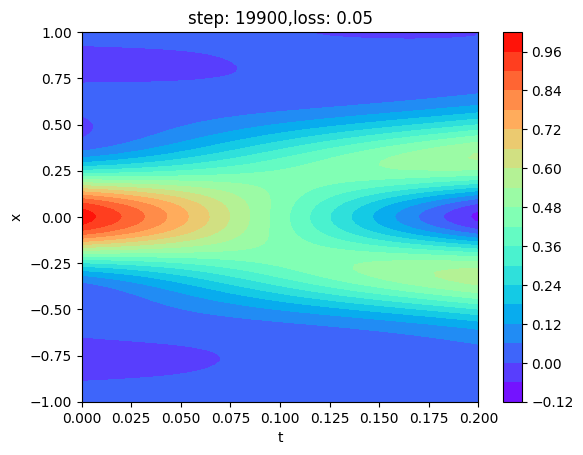

In [11]:
if torch.is_tensor(X_train_Nf) != True:         
    '''Convert to tensor and send to GPU'''
    'Initial conditions'
    X_train_Ini = torch.from_numpy(X_train_Ini).float().to(device)
    Y_train_Ini = torch.from_numpy(Y_train_Ini).float().to(device)
    
    'Boundary conditions'
    X_train_Bound = torch.from_numpy(X_train_Bound).float().to(device)
    
    'Collocation points'
    X_train_Nf = torch.from_numpy(X_train_Nf).float().to(device)
    
    'Testing points/FDTD solutions'
    X_test = torch.from_numpy(X_test).float().to(device)
    Y_test = torch.from_numpy(Y_test).float().to(device)
    
    'Gradient zero'
    f_hat = torch.zeros(X_train_Nf.shape[0],1).to(device)
    p_x_hat = torch.zeros(X_train_Bound.shape[0],1).to(device)

'''For plot figure'''  
x1=X_test[:,0]
t1=X_test[:,1]
arr_x1=x1.reshape(shape=X.shape).transpose(1,0).detach().cpu()
arr_T1=t1.reshape(shape=X.shape).transpose(1,0).detach().cpu()

'''1. Instantiate the model'''
PINN = FCN(layers)
PINN.to(device)

'''2. Define two optimizers and training strategy'''
optimizer1 = torch.optim.Adam(PINN.parameters(), lr=lr)
optimizer2 = torch.optim.LBFGS(PINN.parameters(), lr=lr)
# Enable anomaly detection in autograd.
torch.autograd.set_detect_anomaly(True)
# When to switch LBFGS
SwitchStep = int(steps*4/5)

'''3. Training'''
def closure():
    # 1. Zero out the gradients before the next forward pass
    optimizer2.zero_grad()
    # 2. Calculate the loss and backpropagate it
    loss = PINN.loss(X_train_Bound, X_train_Ini, Y_train_Ini, X_train_Nf)
    loss.backward()
    return loss

# Training steps
for i in range(int(steps)):
    if i == SwitchStep:
        # Switch to L-BFGS optimizer
        optimizer1.zero_grad()
        optimizer2 = optim.LBFGS(PINN.parameters(), lr=lr)

    # 1. Calculate loss
    loss = PINN.loss(X_train_Bound, X_train_Ini, Y_train_Ini, X_train_Nf)

    if i < SwitchStep: # use optimizer 1
        # 2. Clear gradients from the previous iteration
        optimizer1.zero_grad()
        # 3. Back propagate the loss
        loss.backward()
        # 4. Update the model parameters with the calculated gradients
        optimizer1.step()
        # 5. Evaluate the model on the test set and get the predictions
        results = PINN(X_test)
        
    else: # use optimizer 2
        # 2. Update the model parameters with L-BFGS
        optimizer2.step(closure = closure)
        # 3. Evaluate the model on the test set and get the predictions
        results = PINN(X_test)
        
    # Print the loss every 1/200 of the total steps
#     if (i + 1) % int(steps/200) == 0:
#         print(f'Step [{i+1}/{int(steps)}], Loss: {loss.item():.4f}')

    # Plot the results every 1/200 of the total steps
    if i%(steps/200)==0:
        # Reshape the predictions for visualization
        arr_y1 = results.reshape(shape=X.shape).transpose(1,0).detach().cpu()
        # Visualize the model's predictions and the true function
        plot3D_Train(arr_x1,arr_T1,arr_y1,i,loss.detach().cpu().numpy())
        # Clear the previous visualization and display the new one
        display.clear_output(wait=True)
        plt.show()

# Plots: PINN

## 3D plot

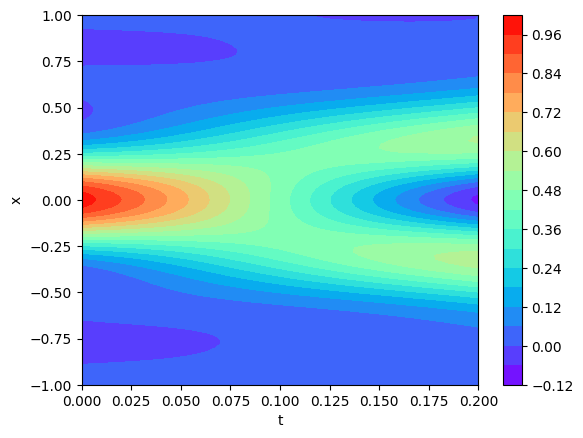

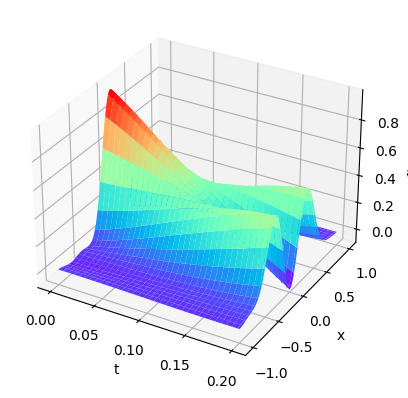

In [12]:
x1=X_test[:,0]
t1=X_test[:,1]
arr_x1=x1.reshape(shape=X.shape).transpose(1,0).detach().cpu()
arr_T1=t1.reshape(shape=X.shape).transpose(1,0).detach().cpu()
arr_y1 = PINN(X_test).reshape(shape=X.shape).transpose(1,0).detach().cpu()
plot3D_Matrix(arr_x1,arr_T1,arr_y1)

## Animation: PINN

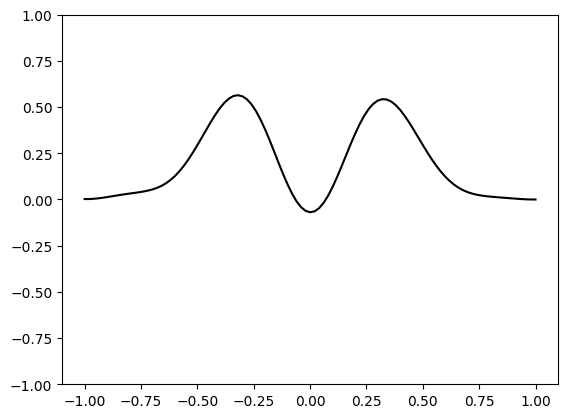

In [13]:
y1 = arr_y1.t()
# Animation
for i in range(nt):
    plt.cla()   # 清除键
    plt.plot(x_FDTD,y1[i,:], 'k')
    plt.ylim([-1,1])
    display.clear_output(wait = True)
    plt.show()

# Reference solution by FDTD

## 3D plot

<Figure size 640x480 with 0 Axes>

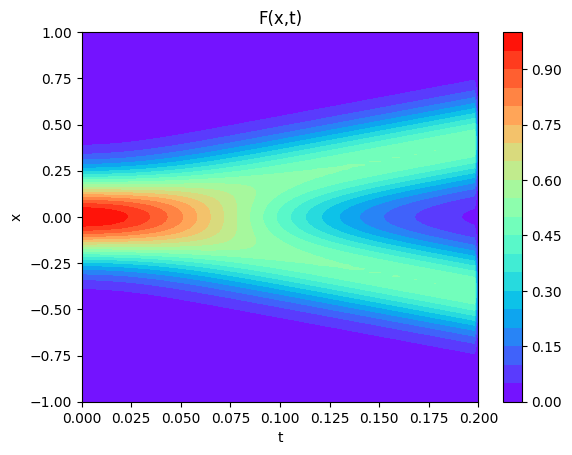

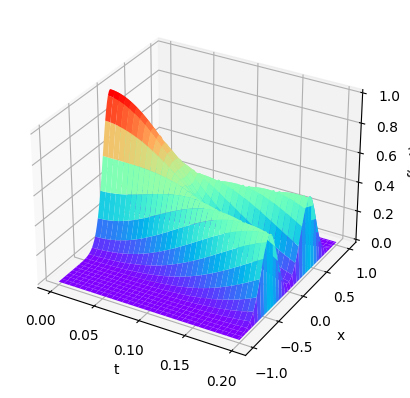

In [14]:
plt.figure()
plot3D(x_FDTD,t_FDTD,u_FDTD)

## Animation

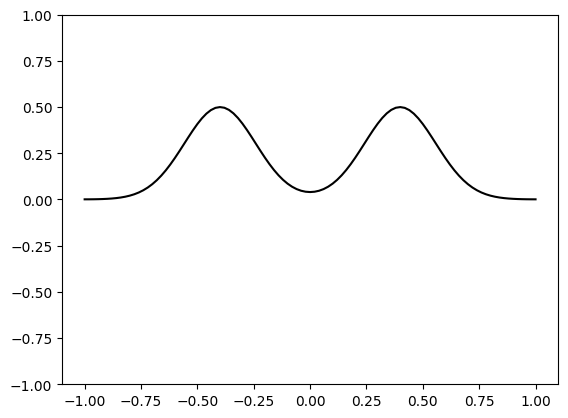

In [15]:
plt.figure()
for i in range(nt):
    plt.cla()   # 清除键
    plt.plot(x_FDTD,u_FDTD[i,:], 'k')
    plt.ylim([-1,1])
    display.clear_output(wait = True)
    plt.show()